<center>
    <h2 style="color: white; background-color: #add8e6; padding: 15px; border-radius: 5px; border: 2px solid black; font-size: 36px; font-weight: bold;">
        Twitter Sentiment Analysis
    </h2>
</center>
er>
er>
er>
er>
>


In this kernel, we will use a Twitter sentiment dataset to explore the workflow of creating sentiment analysis models. We will experiment with a variety of neural networks suitable for this task.

<div style="background-color: #E71E1E; padding: 10px; border-top: 2px solid black; border-bottom: 2px solid black; text-align: center;">
    <h2 style="color: black; font-size: 24px; font-family: Arial, sans-serif;">Importing Libraries</h2>
</div>


In [4]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
import time

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff

#import spacy 
import nltk
nltk.download('wordnet')
#nlp=spacy.load('en_core_web_sm')
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords

from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense,Dropout,Flatten,Embedding,SimpleRNN,LSTM,GRU,Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#from gensim.models import Word2Vec



    

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vasud\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<div style="background-color: #E71E1E; padding: 10px; border-top: 2px solid black; border-bottom: 2px solid black; text-align: center;">
    <h2 style="color: white; font-size: 24px; font-family: Arial, sans-serif;">Importing Dataset and Preprocessing</h2>
</div>


In [5]:
data=pd.read_csv(r"training.1600000.processed.noemoticon.csv",encoding='latin',header=None,on_bad_lines='skip')

In [6]:
data

0           1                             2         3  \
0        0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1        0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2        0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3        0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4        0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
...     ..         ...                           ...       ...   
1599995  4  2193601966  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599996  4  2193601969  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599997  4  2193601991  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599998  4  2193602064  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599999  4  2193602129  Tue Jun 16 08:40:50 PDT 2009  NO_QUERY   

                       4                                                  5  
0        _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1          scotthamilton  is upset that he can't update his Facebook by ...  
2               mattycus  @Kenichan I dived many times for the ball. Man...  
3                ElleCTF    my whole body feels itchy and like its on fire   
4                 Karoli  @nationwideclass no, it's not behaving at all....  
...                  ...                                                ...  
1599995  AmandaMarie1028  Just woke up. Having no school is the best fee...  
1599996      TheWDBoards  TheWDB.com - Very cool to hear old Walt interv...  
1599997           bpbabe  Are you ready for your MoJo Makeover? Ask me f...  
1599998     tinydiamondz  Happy 38th Birthday to my boo of alll time!!! ...  
1599999   RyanTrevMorris  happy #charitytuesday @theNSPCC @SparksCharity...  

[1600000 rows x 6 columns]

In [206]:
df=data.sample(frac=1)[:160000]#Taking a fraction of the dataset just to reduce training time for this notebook

- Let's take an initial look at the dataset

In [207]:
df.sample(5)

0           1                             2         3  \
398050   0  2056788569  Sat Jun 06 11:47:44 PDT 2009  NO_QUERY   
745470   0  2282398890  Mon Jun 22 11:19:09 PDT 2009  NO_QUERY   
922309   4  1754400964  Sun May 10 06:08:27 PDT 2009  NO_QUERY   
1449677  4  2062864075  Sun Jun 07 00:33:22 PDT 2009  NO_QUERY   
378558   0  2052135306  Fri Jun 05 23:46:05 PDT 2009  NO_QUERY   

                      4                                                  5  
398050          JenisaK  Miami is my 2nd home...I just wish the weather...  
745470          kiajas9  I've just taking some allergy tablets...my nos...  
922309   ValentineKathy  My treat today: @Lakers &amp; @OfficialRockets...  
1449677   GeminiTwisted  @DonnieWahlberg Ohhh that's hot!!! P.S. Have I...  
378558     maggiejoella  ahh .what happen to my Iphone. the battery die...

- Only the columns for the tweets and their respective sentiments (columns 0 and 5) are useful to us ,so we'll only take them in our dataframe
- We'll rename these columns to their proper names
- In this dataset,in the sentiments column,the postive sentiments are marked zero and negative sentiments are 4.We'll convert the 4's to 1's for better understaning

In [208]:
df=df[[0,5]]
df.rename(columns={0:'Sentiment',5:'Text'},inplace=True)
df['Sentiment']=df['Sentiment'].replace(4,1) 

Now before we can train Deep Learning models for Twitter Sentiment analysis, we need to preprocess the texts(tweets) in order to optimize both performance and efficiency.

#### Here are the preprocessing steps that we'll perform:
- Convert the whole text to lowercase so that words are not perceived differently just because they are in different cases.
- Use regex to remove special characters, usernames, and hyperlinks as they are redundant to sentiment analy
- Remove Stopwords. Stopwords are commonly occurring words such as "the", "a", "in", "You", "I", "could", etc. that don't contribute much.sis.
- Lemmatize the text (bring them to their base form). You can learn more about lemmatization h much.

<center><img src='https://raw.githubusercontent.com/AshishJangra27/nlp-support/main/Text%20Cleaning.png'6width="400"></center>
center>
center>


In [209]:
def preprocess_tweet2(tweet):
    tweet=tweet.lower()
    tweet = re.sub(r"@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+", ' ', tweet)
    tokens=[token.lemma_ for token in nlp(tweet)]
    tokens=[token for token in tokens if (token not in stop_words) and (len(token)>1)]
    return ' '.join(tokens).strip()
    

In [210]:

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

url_mention_pattern = re.compile(r"(?:\@|https?\://)\S+|[^\w\s#]")

def preprocess_tweet(tweet):
    # Convert to lowercase
    tweet = tweet.lower()
    # Remove URLs, mentions, and non-alphanumeric characters except hashtags
    tweet = url_mention_pattern.sub('', tweet)
    # Tokenize by simple whitespace
    tokens = tweet.split()
    # Lemmatize and filter out stopwords and short tokens
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and len(token) > 1]
    # Join tokens back into a processed tweet
    processed_tweet = ' '.join(lemmatized_tokens)
    return processed_tweet


In [211]:
df['Preprocessed_text']=[preprocess_tweet(txt) for txt in tqdm(df['Text'])]

100%|███████████████████████████████████████████████████████████████████████| 160000/160000 [00:03<00:00, 42474.56it/s]


- Let's add new features for word length and character length in each tweet

In [212]:
df["Preprocessed_text"]

560719               didnt didnt time think going take hubby
1431048                                         shes awesome
1329256                                            ready day
1317212                                         sorry inform
1205689    watching mtv movie award like rest world appar...
                                 ...                        
535360                    havent showered yet today im gross
8407                                            feeling left
154045     home school wont email open going twitter till...
851626                   playing pac man legendary buti died
387785                      ok cool well fun guess dont miss
Name: Preprocessed_text, Length: 160000, dtype: object

In [213]:
df['word_length']=df['Preprocessed_text'].apply(lambda x: len(x.split(" ")))
df['char_length']=df['Preprocessed_text'].apply(lambda x: len(x))

In [214]:
df.head()

Sentiment                                               Text  \
560719           0  @the_fool_monty I didn't. Didn't have time.  I...   
1431048          1                   @takethatsucker  She's awesome!    
1329256          1                               is ready for day 2.    
1317212          1     @garethhinchley sorry to inform you, but I am    
1205689          1  watching MTV movie awards, like the rest of th...   

                                         Preprocessed_text  word_length  \
560719             didnt didnt time think going take hubby            7   
1431048                                       shes awesome            2   
1329256                                          ready day            2   
1317212                                       sorry inform            2   
1205689  watching mtv movie award like rest world appar...            8   

         char_length  
560719            39  
1431048           12  
1329256            9  
1317212           12  
1205689           51

<div style="background-color: #E71E1E; padding: 10px; border-top: 2px solid black; border-bottom: 2px solid black; text-align: center;">
    <h2 style="color: white; font-size: 24px; font-family: Arial, sans-serif;">EDA</h2>
</div>


Let's perform some basic Exploratory Data Analysis to gain insights about our data

In [46]:
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [45]:
"won't" in stop_words

True

In [58]:
positive_count=len(df[df['Sentiment']==1])
negative_count=len(df[df['Sentiment']==0])

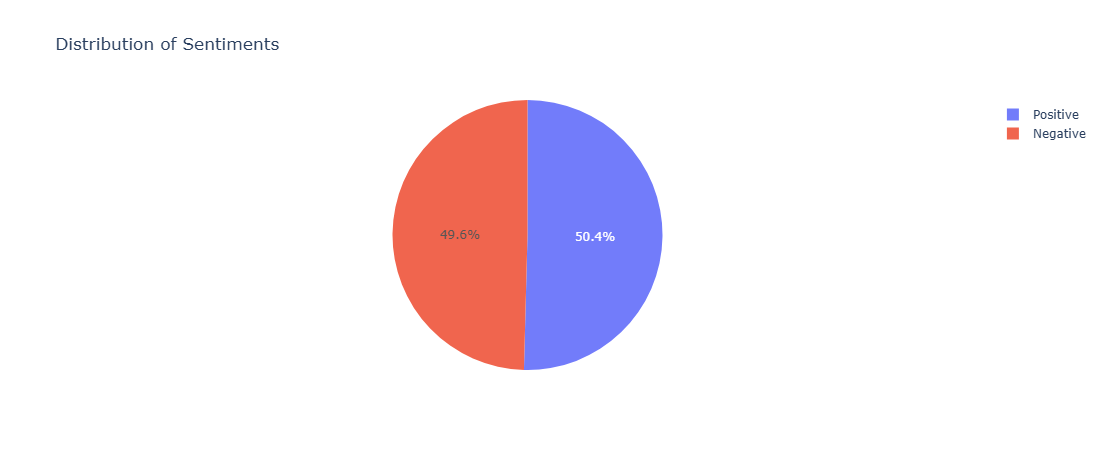

In [152]:
fig=px.pie(values=[positive_count,negative_count],title="Distribution of Sentiments",names=['Positive','Negative'],hover_name=['Positive','Negative'],opacity=0.9,template="plotly_white",)
fig.update_layout(width=600, height=450)
fig.show()

- The dataset is almost equally divided between negative sentiment tweets and positive sentiment tweets.This means that we can use accuracy as a metric.

Now we'll plot a wordcloud for our dataset. In simple terms,the word cloud will give us an idea of what words are prominent and occur more frequently in which .The bigger the word is displayed in word cloud,the more frequent it is.

In [132]:
from wordcloud import WordCloud

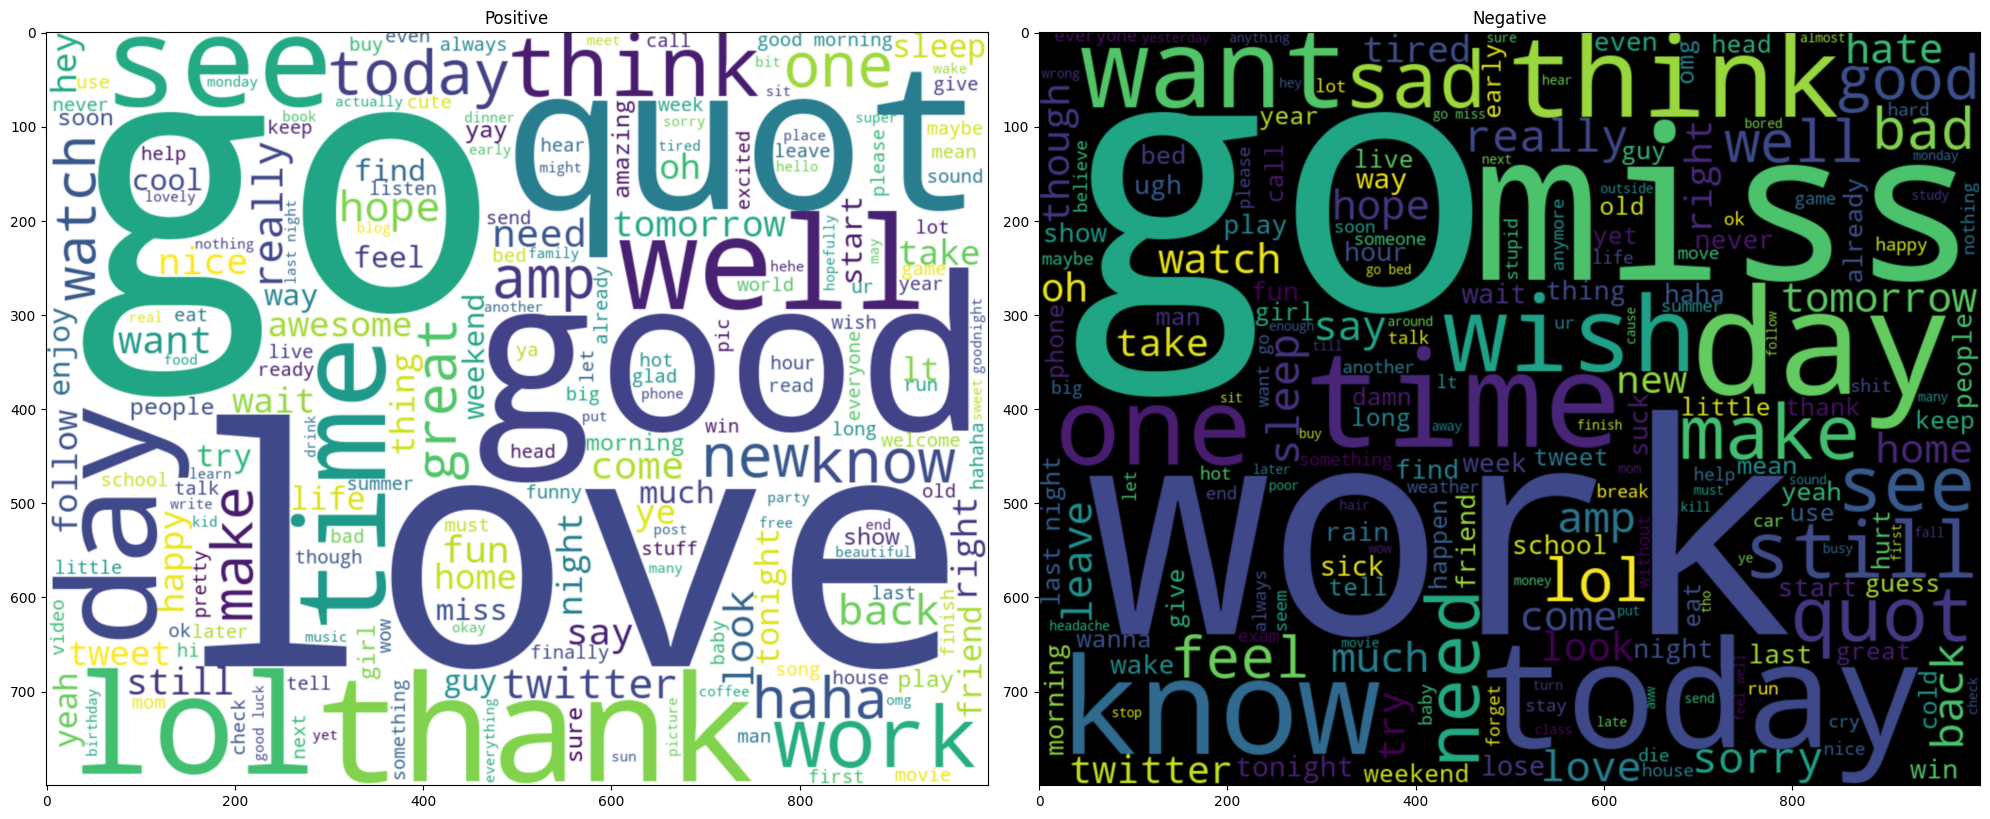

In [29]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
wordcloud_1=WordCloud(height=800,width=1000,background_color='white',random_state=42).generate(' '.join(df[df['Sentiment']==1]['Preprocessed_text']))
plt.imshow(wordcloud_1,interpolation='bicubic')
plt.title("Positive")

plt.subplot(1,2,2)
wordcloud_2=WordCloud(height=800,width=1000,background_color='black',random_state=42).generate(' '.join(df[df['Sentiment']==0]['Preprocessed_text']))
plt.imshow(wordcloud_2,interpolation='bicubic')
plt.title("Negative")

plt.tight_layout()
plt.show()

- The word cloud on the left is showing us the most prominent words in positive tweets and the word cloud on the right is showing us the most prominent words in negative texts

Let's also see the distribution of frequency of words in tweets as a function of  sentiments

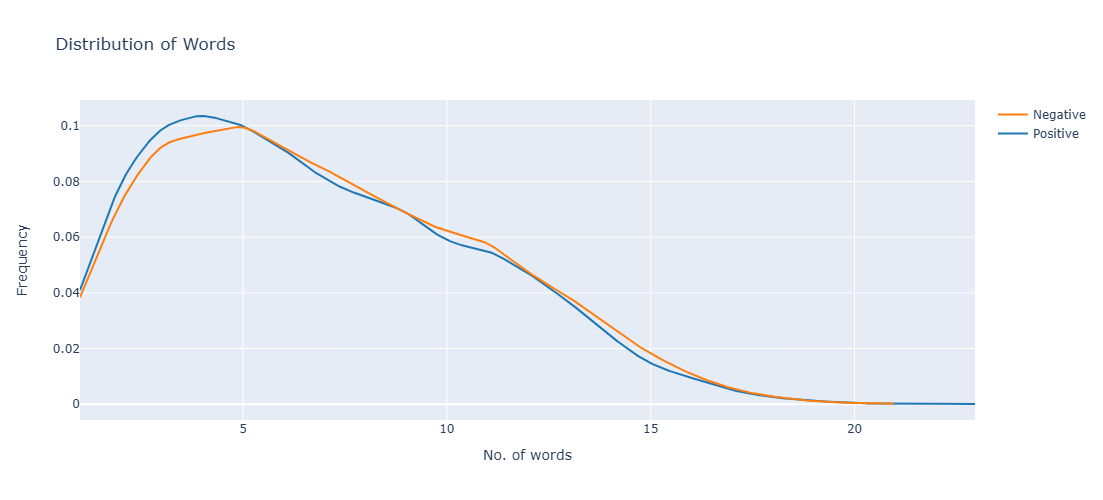

In [18]:
fig_words=ff.create_distplot([df[df['Sentiment']==1]['word_length'],df[df['Sentiment']==0]['word_length']],['Positive','Negative'],bin_size=25,show_hist=False,show_rug=False)
fig_words.update_layout(title="Distribution of Words",xaxis_title='No. of words',yaxis_title='Frequency',height=500,width=700)
fig_words.show()

<div style="background-color: #E71E1E; padding: 10px; border-top: 2px solid black; border-bottom: 2px solid black; text-align: center;">
    <h2 style="color: black; font-size: 24px; font-family: Arial, sans-serif;">Encoding</h2>
</div>


 Neural networks can't directly process the text data of tweets. Thus, we need to convert that text data into a numerical form that neural networks can understand. Here are several significant encoding methods:

  **1. One-Hot Encoding**:
  - In one-hot encoding, each word in the vocabulary of the dataset is represented as a feature. The presence of a word in a tweet is indicated by a 1, and the absence by 

    
<center> <img src = 'https://raw.githubusercontent.com/AshishJangra27/nlp-support/main/One%20Hot%20Encoding.png'></center>a 0.

  **2. Count Vectorization**:
  - Similar to one-hot encoding, but instead of indicating the presence of each word with 0s and 1s, we use the frequency (count) of each word in th
e<center> <img src = 'https://raw.githubusercontent.com/AshishJangra27/nlp-support/main/Count%20Vectorizer.png'></center>
 tweet.

  **3. TF-IDF Vectorization**:
  - TF-IDF (Term Frequency-Inverse Document Frequency) is a more advanced form of vectorization. It decreases the importance of a word if it occurs frequently throughout the document corpus, thereby highlighting words that are more significant in specif​
<center> <img src = 'https://raw.githubusercontent.com/AshishJangra27/nlp-support/main/TF-IDF.png'></center>
ic tweets.

  **4. Sequence Encoding**:
  - Sequence encoding involves converting tweets into sequences of integers, where each integer represents a specific word in the vocabulary. This is crucial for models that process text as a sequ​
<center> <img src = 'https://raw.githubusercontent.com/AshishJangra27/nlp-support/main/Index%20based%20Encoding.png'></center>>
ence of words.

  **5. Embedding Layer**:
  - Embedding layers transform sequences of integers into dense vectors of fixed size, based on their semantic meaning. This method captures the context of words within tweets by positioning them in a continuous vector space, which is then f
<center> <img src = 'https://raw.githubusercontent.com/AshishJangra27/nlp-support/main/Word%20Embedding.png'></center>
​ed into the model.


### Splitting the dataset:
Before encoding,let us split the dataset into training,validation,and testing data. Since our dataset is fairly large,we will use a 90-5-5 split.

In [215]:
# Step 1: Split the raw data into training, validation, and test sets
x_train, x_test, y_train, y_test = train_test_split(df['Preprocessed_text'], df['Sentiment'], test_size=0.2, random_state=10)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=10)

# Step 2: Fit the encoders on the entire dataset
# One-Hot Encoding
vec_ohe = CountVectorizer(binary=True)
vec_ohe.fit(df['Preprocessed_text'])
x_train_ohe = vec_ohe.transform(x_train)
x_val_ohe = vec_ohe.transform(x_val)
x_test_ohe = vec_ohe.transform(x_test)
# Count Vectorization
vec_cv = CountVectorizer(binary=False)
vec_cv.fit(df['Preprocessed_text'])
x_train_cv = vec_cv.transform(x_train)
x_val_cv = vec_cv.transform(x_val)
x_test_cv = vec_cv.transform(x_test)
# TF-IDF Vectorization
tfidf = TfidfVectorizer()
tfidf.fit(df['Preprocessed_text'])
x_train_tfidf = tfidf.transform(x_train)
x_val_tfidf = tfidf.transform(x_val)
x_test_tfidf = tfidf.transform(x_test)
# Tokenization and Padding for Sequence Models
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Preprocessed_text'])
word_index = tokenizer.word_index
index_word = tokenizer.index_word

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_val_seq = tokenizer.texts_to_sequences(x_val)
x_test_seq = tokenizer.texts_to_sequences(x_test)
x_train_seq = pad_sequences(x_train_seq, maxlen=20, padding='post')
x_val_seq = pad_sequences(x_val_seq, maxlen=20, padding='post')
x_test_seq = pad_sequences(x_test_seq, maxlen=20, padding='post')

<div style="background-color: #E71E1E; padding: 10px; border-top: 2px solid black; border-bottom: 2px solid black; text-align: center;">
    <h2 style="color: black; font-size: 24px; font-family: Arial, sans-serif;">Modelling</h2>
</div>


Here's a brief overview of the modelling steps we are going to take


### Baseline Model
First,we will create a baseline model to establish a performance benchmark and understand the complexity of the task.I'll be using a simple Logistic Regression Classifier paired with OneHotEncoder for this.

### Neural Network Exploration
Then,we explore various neural netwroks.
#### Multilayer Perceptron (MLP)
- **Technique**: Utilize different encoding methods
- **Purpose**: Compare basic neural network performance against the logistic regression baseline.

#### Sequence-Based Models: Numerical Sequencing and Embeddings
- **Sequencing Models**: These models consider the order of words in the text, which is crucial for capturing context and dependencies in language. Numerical sequencing involves converting each tweet into a sequence of integers, where each integer represents a specific word.
- **Purpose**: By using embeddings, these models transform sequences into dense vectors that encapsulate semantic meanings, allowing the network to learn relationships between words.

#### Advanced Sequence Model Architectures
- **RNN (Recurrent Neural Network)**:
  - **Purpose**: Processes sequences by maintaining a hidden state that carries information across timesteps, capturing temporal dependencies.
- **LSTM (Long Short-Term Memory)**: 
  - **Purpose**: Captures long-term dependencies in text data, essential for understanding context and sentiment over longer sequences.
- **GRU (Gated Recurrent Unit)**: 
  - **Purpose**: Offers a simpler and more computationally efficient alternative to LSTMs, while still effectively capturing dependencies in sequences.
- **Bidirectional LSTM**: 
  - **Purpose**: Enhances context understanding by processing text in both forward and backward directions, providing a more comprehensive grasp of the sequence.



In [216]:
model_performances=pd.DataFrame(columns=["Name","Validation Accuracy","Test Accuracy","Training Time"],data=None)

### 1.  OneHotEncoder + Logistic Regression 

In [217]:
initial=time.time()
lr=LogisticRegression()
lr.fit(x_train_ohe,y_train)
training_time=time.time()-initial
preds=lr.predict(x_test_ohe)
score=accuracy_score(y_test,preds)

model_performances=pd.concat([model_performances,pd.DataFrame({
    "Name":["Logistic Regression + OHE"],
    "Validation Accuracy":[score],
    "Test Accuracy":[score],
    "Training Time":[training_time]
})],ignore_index=True)

### 2.  OneHotEncoder + MLP

In [201]:
import keras
keras.__version__

'3.3.3'

In [199]:
import tensorflow as tf
tf.__version__

'2.16.1'

In [197]:

model=Sequential()
model.add(Dense(512,activation='relu',input_shape=(x_train_ohe.shape[1],)))
model.add(Dense(128,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

epochs=2
batch_size=256

initial=time.time()
history=model.fit(x_train_ohe,y_train,epochs=epochs,batch_size=batch_size,validation_data=(x_val_ohe,y_val)  )
training_time=time.time()-initial

model_performances=pd.concat([model_performances,pd.DataFrame({
    "Name":["OHE+MLP "],
    "Validation Accuracy":[max(history_1.history['val_accuracy'])],
    "Test Accuracy":[model.evaluate(x_test_ohe,y_test)[1]],
    "Training Time":[training_time]
})],ignore_index=True)

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_62 (Dense)                     │ (None, 512)                 │      32,694,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_63 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_64 (Dense)                     │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_65 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,764,609 (124.99 MB)

 Trainable params: 32,764,609 (124.99 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 48s 149ms/step - accuracy: 0.7147 - loss: 0.5583 - val_accuracy: 0.7676 - val_loss: 0.4907
Epoch 2/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 46s 146ms/step - accuracy: 0.8566 - loss: 0.3313 - val_accuracy: 0.7567 - val_loss: 0.5586
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - accuracy: 0.7560 - loss: 0.5587


In [195]:

model=Sequential()
model.add(Dense(512,activation='relu',input_shape=(x_train_ohe.shape[1],)))
model.add(Dense(128,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

epochs=10
batch_size=256

initial=time.time()
history=model.fit(x_train_ohe,y_train,epochs=epochs,batch_size=batch_size,validation_data=(x_val_ohe,y_val)  )
training_time=time.time()-initial

model_performances=pd.concat([model_performances,pd.DataFrame({
    "Name":["OHE+MLP "],
    "Validation Accuracy":[max(history_1.history['val_accuracy'])],
    "Test Accuracy":[model.evaluate(x_test_ohe,y_test)[1]],
    "Training Time":[training_time]
})],ignore_index=True)

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_54 (Dense)                     │ (None, 512)                 │      32,694,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_55 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_56 (Dense)                     │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_57 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,764,609 (124.99 MB)

 Trainable params: 32,764,609 (124.99 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 48s 148ms/step - accuracy: 0.7100 - loss: 0.5611 - val_accuracy: 0.7665 - val_loss: 0.4869
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 45s 145ms/step - accuracy: 0.8597 - loss: 0.3246 - val_accuracy: 0.7578 - val_loss: 0.5613
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 46s 145ms/step - accuracy: 0.9450 - loss: 0.1410 - val_accuracy: 0.7540 - val_loss: 0.8144
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 45s 145ms/step - accuracy: 0.9823 - loss: 0.0477 - val_accuracy: 0.7443 - val_loss: 1.1220
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 46s 146ms/step - accuracy: 0.9900 - loss: 0.0258 - val_accuracy: 0.7367 - val_loss: 1.3733
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 46s 145ms/step - accuracy: 0.9925 - loss: 0.0192 - val_accuracy: 0.7447 - val_loss: 1.4259
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 46s 146ms/step - accuracy: 0.9931 - loss: 0.0174 - val_accuracy: 0.7454 - val_loss: 1.5131
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 47s 151ms/step - accuracy: 0.9924 - loss: 0

### 2. CountVectorizer + MLP

In [205]:
model=Sequential()
model.add(Dense(512,activation='relu',input_shape=(x_train_cv.shape[1],)))
model.add(Dense(128,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

epochs=10
batch_size=32

initial=time.time()
history=model.fit(x_train_cv,y_train,epochs=epochs,batch_size=batch_size,validation_data=(x_val_cv,y_val) , callbacks=[early_stopping] )
training_time=time.time()-initial

model_performances=pd.concat([model_performances,pd.DataFrame({
    "Name":["CountVectorizer + MLP"],
    "Validation Accuracy":[max(history.history['val_accuracy'])],
    "Test Accuracy":[model.evaluate(x_test_cv,y_test)[1]],
    "Training Time":[training_time]
})],ignore_index=True)

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_66 (Dense)                     │ (None, 512)                 │      32,694,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_67 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_68 (Dense)                     │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_69 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,764,609 (124.99 MB)

 Trainable params: 32,764,609 (124.99 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 367s 146ms/step - accuracy: 0.7196 - loss: 0.5491 - val_accuracy: 0.7697 - val_loss: 0.4924
Epoch 2/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 358s 143ms/step - accuracy: 0.8585 - loss: 0.3258 - val_accuracy: 0.7570 - val_loss: 0.5642
Epoch 3/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 350s 140ms/step - accuracy: 0.9581 - loss: 0.1093 - val_accuracy: 0.7494 - val_loss: 0.8781
Epoch 4/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 348s 139ms/step - accuracy: 0.9862 - loss: 0.0363 - val_accuracy: 0.7505 - val_loss: 1.3284
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - accuracy: 0.7611 - loss: 0.4976


### 3. Tfidf + MLP

In [196]:

model=Sequential()
model.add(Dense(512,activation='relu',input_shape=(x_train_tfidf.shape[1],)))
model.add(Dense(128,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

epochs=10
batch_size=256

initial=time.time()
history=model.fit(x_train_tfidf,y_train,epochs=epochs,batch_size=batch_size,validation_data=(x_val_tfidf,y_val) , callbacks=[early_stopping])
training_time=time.time()-initial

model_performances=pd.concat([model_performances,pd.DataFrame({
    "Name":["Tfidf + MLP "],
    "Validation Accuracy":[max(history.history['val_accuracy'])],
    "Test Accuracy":[model.evaluate(x_test_tfidf,y_test)[1]],
    "Training Time":[training_time]
})],ignore_index=True)

Epoch 1/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 365s 146ms/step - accuracy: 0.7149 - loss: 0.5468 - val_accuracy: 0.7670 - val_loss: 0.4834
Epoch 2/10
1207/2500 ━━━━━━━━━━━━━━━━━━━━ 3:02 141ms/step - accuracy: 0.8597 - loss: 0.3281

KeyboardInterrupt: 

In [221]:
img = []
for i in range(256,0,-1): 
    t=[]
    for j in range(1024): 
        append([1,0,0]) img.append(t)
img = np.array(img)
plt.imshow(img)

SyntaxError: invalid syntax (1614321910.py, line 3)

### 4. Embedding Layer + MLP

In [218]:
model=Sequential()
model.add(Embedding(input_dim=len(word_index)+1,output_dim=100,input_length=20))
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

epochs=10
batch_size=256

initial=time.time()
history=model.fit(x_train_seq,y_train,epochs=epochs,batch_size=batch_size,validation_data=(x_val_seq,y_val) , callbacks=[early_stopping])
training_time=time.time()-initial

model_performances=pd.concat([model_performances,pd.DataFrame({
    "Name":[" Embedding Layer + MLP"],
    "Validation Accuracy":[max(history.history['val_accuracy'])],
    "Test Accuracy":[model.evaluate(x_test_seq,y_test)[1]],
    "Training Time":[training_time]
})],ignore_index=True)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - accuracy: 0.6884 - loss: 0.5711 - val_accuracy: 0.7684 - val_loss: 0.4813
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.8476 - loss: 0.3560 - val_accuracy: 0.7487 - val_loss: 0.5268
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.9243 - loss: 0.1918 - val_accuracy: 0.7347 - val_loss: 0.6629
Epoch 4/10
107/500 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9570 - loss: 0.1123

KeyboardInterrupt: 

### 5. Embedding Layer+ RNN

In [154]:
model=Sequential()
model.add(Embedding(input_dim=len(word_index)+1,output_dim=100,input_length=20))
model.add(SimpleRNN(units=100,dropout=.2,return_sequences=True))
model.add(SimpleRNN(units=50))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

epochs=10
batch_size=32

initial=time.time()
history=model.fit(x_train_seq,y_train,epochs=epochs,batch_size=batch_size,validation_data=(x_val_seq,y_val) , callbacks=[early_stopping])
training_time=time.time()-initial

model_performances=pd.concat([model_performances,pd.DataFrame({
    "Name":["Embedding Layer+ RNN"],
    "Validation Accuracy":[max(history.history['val_accuracy'])],
    "Test Accuracy":[model.evaluate(x_test_seq,y_test)[1]],
    "Training Time":[training_time]
})],ignore_index=True)

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_3 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.5344 - loss: 0.6977 - val_accuracy: 0.6530 - val_loss: 0.6305
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7120 - loss: 0.5867 - val_accuracy: 0.6790 - val_loss: 0.6282
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8037 - loss: 0.4636 - val_accuracy: 0.6805 - val_loss: 0.5923
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8640 - loss: 0.3599 - val_accuracy: 0.6765 - val_loss: 0.7071
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8942 - loss: 0.2935 - val_accuracy: 0.6785 - val_loss: 0.7786
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9171 - loss: 0.2230 - val_accuracy: 0.6725 - val_loss: 0.8840
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9295 - loss: 0.1887 - val_accuracy: 0.6610 - val_loss: 0.8186
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9410 - loss: 0.1705 - val_accu

### 6. Embedding Layer+ LSTM

In [155]:
model=Sequential()
model.add(Embedding(input_dim=len(word_index)+1,output_dim=100,input_length=20))
model.add(LSTM(units=100,dropout=.2,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

epochs=10
batch_size=32

initial=time.time()
history=model.fit(x_train_seq,y_train,epochs=epochs,batch_size=batch_size,validation_data=(x_val_seq,y_val), callbacks=[early_stopping] )
training_time=time.time()-initial

model_performances=pd.concat([model_performances,pd.DataFrame({
    "Name":["Embedding Layer+ LSTM"],
    "Validation Accuracy":[max(history.history['val_accuracy'])],
    "Test Accuracy":[model.evaluate(x_test_seq,y_test)[1]],
    "Training Time":[training_time]
})],ignore_index=True)

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.5798 - loss: 0.6623 - val_accuracy: 0.7240 - val_loss: 0.5477
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.7942 - loss: 0.4706 - val_accuracy: 0.7270 - val_loss: 0.5512
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8552 - loss: 0.3653 - val_accuracy: 0.7220 - val_loss: 0.5789
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8929 - loss: 0.2802 - val_accuracy: 0.7120 - val_loss: 0.7171
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9129 - loss: 0.2245 - val_accuracy: 0.6975 - val_loss: 0.7650
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9277 - loss: 0.1924 - val_accuracy: 0.6945 - val_loss: 0.9928
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9368 - loss: 0.1543 - val_accuracy: 0.6990 - val_loss: 0.9513
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9459 - loss: 0.1312 - val_acc

### 7. Embedding+GRU

In [156]:
model=Sequential()
model.add(Embedding(input_dim=len(word_index)+1,output_dim=100,input_length=20))
model.add(GRU(units=100,dropout=.2,return_sequences=True))
model.add(GRU(units=50))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

epochs=10
batch_size=32

initial=time.time()
history=model.fit(x_train_seq,y_train,epochs=epochs,batch_size=batch_size,validation_data=(x_val_seq,y_val), callbacks=[early_stopping] )
training_time=time.time()-initial

model_performances=pd.concat([model_performances,pd.DataFrame({
    "Name":["Embedding+GRU"],
    "Validation Accuracy":[max(history.history['val_accuracy'])],
    "Test Accuracy":[model.evaluate(x_test_seq,y_test)[1]],
    "Training Time":[training_time]
})],ignore_index=True)

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.5027 - loss: 0.6941 - val_accuracy: 0.5050 - val_loss: 0.6931
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.5919 - loss: 0.6511 - val_accuracy: 0.7410 - val_loss: 0.5343
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8180 - loss: 0.4409 - val_accuracy: 0.7280 - val_loss: 0.5602
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8784 - loss: 0.3101 - val_accuracy: 0.7025 - val_loss: 0.6372
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9169 - loss: 0.2198 - val_accuracy: 0.6960 - val_loss: 0.7689
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.9390 - loss: 0.1633 - val_accuracy: 0.7055 - val_loss: 0.9575
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9485 - loss: 0.1312 - val_accuracy: 0.6925 - val_loss: 1.1035
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9597 - loss: 0.1010 - val_acc

### 8. Embedding+Birdirectional+GRU

In [157]:
model=Sequential()
model.add(Embedding(input_dim=len(word_index)+1,output_dim=100,input_length=20))
model.add(Bidirectional(GRU(units=100,dropout=.2,return_sequences=True)))
model.add(Bidirectional(GRU(units=50)))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

epochs=10
batch_size=32

initial=time.time()
history=model.fit(x_train_seq,y_train,epochs=epochs,batch_size=batch_size,validation_data=(x_val_seq,y_val), callbacks=[early_stopping] )
training_time=time.time()-initial

model_performances=pd.concat([model_performances,pd.DataFrame({
    "Name":["Embedding+Birdirectional+GRU"],
    "Validation Accuracy":[max(history.history['val_accuracy'])],
    "Test Accuracy":[model.evaluate(x_test_seq,y_test)[1]],
    "Training Time":[training_time]
})],ignore_index=True)

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.6146 - loss: 0.6373 - val_accuracy: 0.7345 - val_loss: 0.5300
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8231 - loss: 0.4178 - val_accuracy: 0.7190 - val_loss: 0.5903
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8905 - loss: 0.2853 - val_accuracy: 0.7050 - val_loss: 0.6585
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9283 - loss: 0.1938 - val_accuracy: 0.7060 - val_loss: 0.8483
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9467 - loss: 0.1464 - val_accuracy: 0.7020 - val_loss: 0.8763
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9545 - loss: 0.1165 - val_accuracy: 0.6935 - val_loss: 1.1256
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9625 - loss: 0.0966 - val_accuracy: 0.6900 - val_loss: 1.3527
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9635 - loss: 0.0888 - v

<div style="background-color: #E71E1E; padding: 10px; border-top: 2px solid black; border-bottom: 2px solid black; text-align: center;">
    <h2 style="color: black; font-size: 24px; font-family: Arial, sans-serif;">Overview</h2>
</div>


Now that we've trained a lot of models,let's see how they stand

In [161]:
model_performances

Name  Validation Accuracy  Test Accuracy  \
0     Logistic Regression + OHE               0.7210         0.7210   
1                      OHE+MLP                0.7360         0.7210   
2         CountVectorizer + MLP               0.7380         0.7015   
3                  Tfidf + MLP                0.7325         0.6990   
4         Embedding Layer + MLP               0.7270         0.6660   
5          Embedding Layer+ RNN               0.6805         0.6680   
6         Embedding Layer+ LSTM               0.7270         0.6845   
7                 Embedding+GRU               0.7410         0.6845   
8  Embedding+Birdirectional+GRU               0.7345         0.6885   

   Training Time  
0      10.467670  
1     250.940480  
2     247.366893  
3     238.392622  
4      49.316994  
5      61.682277  
6      83.252571  
7      82.768046  
8     101.752367

- Lets see it on a graph:

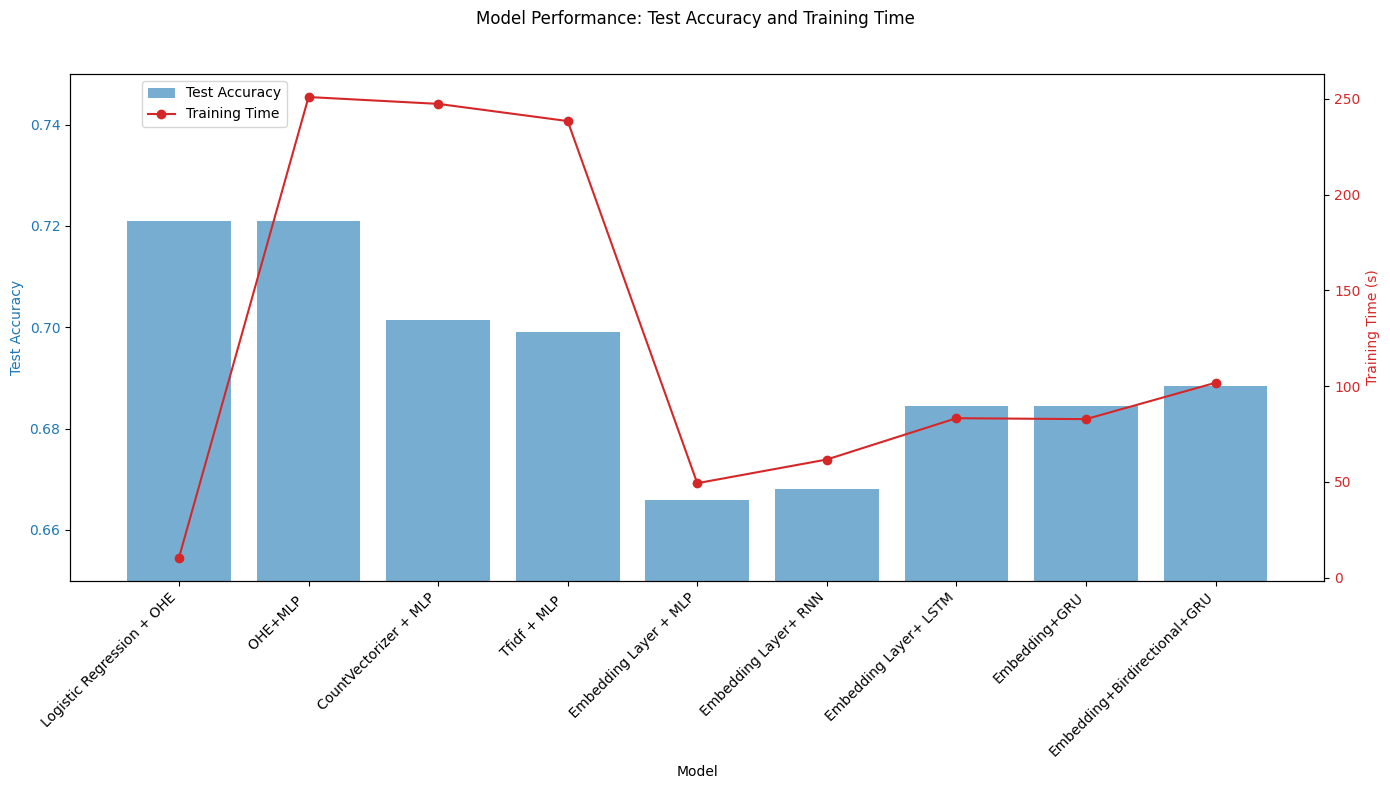

In [163]:
fig, ax1 = plt.subplots(figsize=(14, 8))

color = 'tab:blue'
ax1.set_xlabel('Model')
ax1.set_ylabel('Test Accuracy', color=color)
ax1.bar(model_performances['Name'], model_performances['Test Accuracy'], color=color, alpha=0.6, label='Test Accuracy')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticklabels(model_performances['Name'], rotation=45, ha='right')
ax1.set_ylim(0.65, 0.75)  # Adjusting the y-axis limits for better visibility

ax2 = ax1.twinx() 
color = 'tab:red'
ax2.set_ylabel('Training Time (s)', color=color)
ax2.plot(model_performances['Name'], model_performances['Training Time'], color=color, marker='o', label='Training Time')
ax2.tick_params(axis='y', labelcolor=color)

fig.suptitle('Model Performance: Test Accuracy and Training Time')
fig.tight_layout()
fig.subplots_adjust(top=0.9)

fig.legend(loc="upper left", bbox_to_anchor=(0.1,0.9))

plt.show()

- We can clearly observe how different models are performing in our use case and make decisions based on the tradeoff between model complexity and performance. Of course, we can also use other metrics to analyze models, but I've used accuracy here for simplicity's sake.



<div style="background-color: #E71E1E; padding: 10px; border-top: 2px solid black; border-bottom: 2px solid black; text-align: center;">
    <h2 style="color: black; font-size: 24px; font-family: Arial, sans-serif;">Future Work</h2>
</div>

- **Explore Additional Models:** Try out other models such as pre-trained BERT models, which are known to be state-of-the-art for NLP tasks.
- **Fine-Tuning: Fine-tune some** of the existing models to look for potential improvements in performance.
- **Ensemble Methods**: Experiment with ensemble methods to combine the strengths of multiple models for better accuracy and robustness.
- **Feature Engineering**: Explore additional feature engineering techniques to enhance the input data representation and potentially improve model accuracy.
- **Evaluation Metrics**: Incorporate additional evaluation metrics such as F1 Score, Precision, Recall, and AUC-ROC to gain a more comprehensive understanding of model performance.

<div style="background-color: #f0f0f0; padding: 20px; border-radius: 10px; border: 2px solid #ccc; text-align: center;">
    <h2 style="color: #333; font-family: Arial, sans-serif; font-size: 28px; font-weight: bold; text-shadow: 2px 2px 4px rgba(0,0,0,0.3);">
        Thank you!<br>
        Please consider upvoting
    </h2>
</div>


In [ ]:
embedding_len = 300

word2vec = Word2Vec(list(map(lambda x: word_tokenize(x), df['clean_tweets'])),
                 vector_size = embedding_len,
                 workers=8,
                 min_count = 1)

print("Vocabulary Length:", len(word2vec.wv.key_to_index))

In [ ]:
embedding_matrix = np.zeros((len(word2vec.wv.key_to_index), embedding_len))

for word, token in tokenizer.word_index.items():
    if word2vec.wv.__contains__(word):
        embedding_matrix[token] = word2vec.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

In [ ]:
model = Sequential()

model.add(Embedding(input_dim = len(word2vec.wv.key_to_index),output_dim = embedding_len,weights=[embedding_matrix],input_length = seq_len,trainable = False))
model.add(Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)))
model.add(Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)))
model.add(GlobalMaxPooling1D())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate = 0.0001), metrics=['accuracy'])

history_12 = model.fit(x_train, y_train, epochs = epochs_, batch_size = batch_size_, validation_data=(x_val, y_val))
print('\n')